# YOLOv8 Training with MLflow Integration

This notebook demonstrates how to train a YOLOv8 model and automatically track the experiment using MLflow.

**Workflow:**
1.  **Setup:** Import necessary libraries.
2.  **Configure MLflow:** Set an experiment name to organize our runs.
3.  **Load Model:** Load a pretrained YOLOv8 model.
4.  **Train Model:** Start the training process. `ultralytics` will automatically log metrics, parameters, and the final model to MLflow.
5.  **View Results:** Check the MLflow UI to see the tracked run.

In [1]:
import mlflow
from ultralytics import YOLO
import os

### 1a. Check for GPU Availability

Before we start, let's verify if a GPU is available. Training on a GPU is significantly faster. We'll use `torch` (the backend for `ultralytics`) to check for CUDA-enabled GPUs. We also run the `!nvidia-smi` command for a detailed hardware report.

In [2]:
import torch

if torch.cuda.is_available():
    print(f"GPU is available.")
    device_count = torch.cuda.device_count()
    print(f"Found {device_count} GPU(s).")
    for i in range(device_count):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("No GPU available, training will run on the CPU.")

# For a detailed report, you can run the nvidia-smi command
!nvidia-smi

GPU is available.
Found 1 GPU(s).
GPU 0: NVIDIA GeForce RTX 3090
Mon Jul 21 22:24:26 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.75                 Driver Version: 566.24         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3090        On  |   00000000:51:00.0  On |                  N/A |
|  0%   33C    P8             13W /  350W |     800MiB /  24576MiB |     14%      Default |
|                                         |                        |       

### 1b. Data Preparation: Loading and Splitting the Shelterbelt Dataset

This section covers the entire data preparation pipeline:
1.  **Load Annotations**: Read the COCO-formatted JSON file.
2.  **Process & Visualize**: Organize annotations by image and visualize them to ensure they are correct.
3.  **Split Data**: Divide the dataset into training, validation, and test sets.
4.  **Convert to YOLO Format**: Convert COCO annotations to the YOLO `.txt` format and create the required directory structure.
5.  **Create `data.yaml`**: Generate the dataset configuration file for YOLO.

In [85]:
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from sklearn.model_selection import train_test_split
import shutil

# --- User-defined paths ---
# IMPORTANT: Update these paths to match your environment.
annot_file = r'data/USASK_DL_Forest/labels_shelterbelt_usask_2025-07-21-01-30-59.json'
image_folder_path = 'data/USASK_DL_Forest/images'
# ---

# Load the COCO-format annotation file
with open(annot_file, 'r') as f:
    coco_data = json.load(f)

# Create a mapping from image_id to file_name and dimensions
image_info_map = {img['id']: img for img in coco_data['images']}

# Group annotations by filename for easier access
annotations_dict = {img['file_name']: [] for img in coco_data['images']}
for annotation in coco_data['annotations']:
    image_id = annotation['image_id']
    filename = image_info_map[image_id]['file_name']
    annotations_dict[filename].append(annotation)

print(f"Loaded annotations for {len(annotations_dict)} images.")

Loaded annotations for 98 images.


#### Visualize Annotations
Let's display a few images with their segmentation polygons to verify the data is loaded correctly.

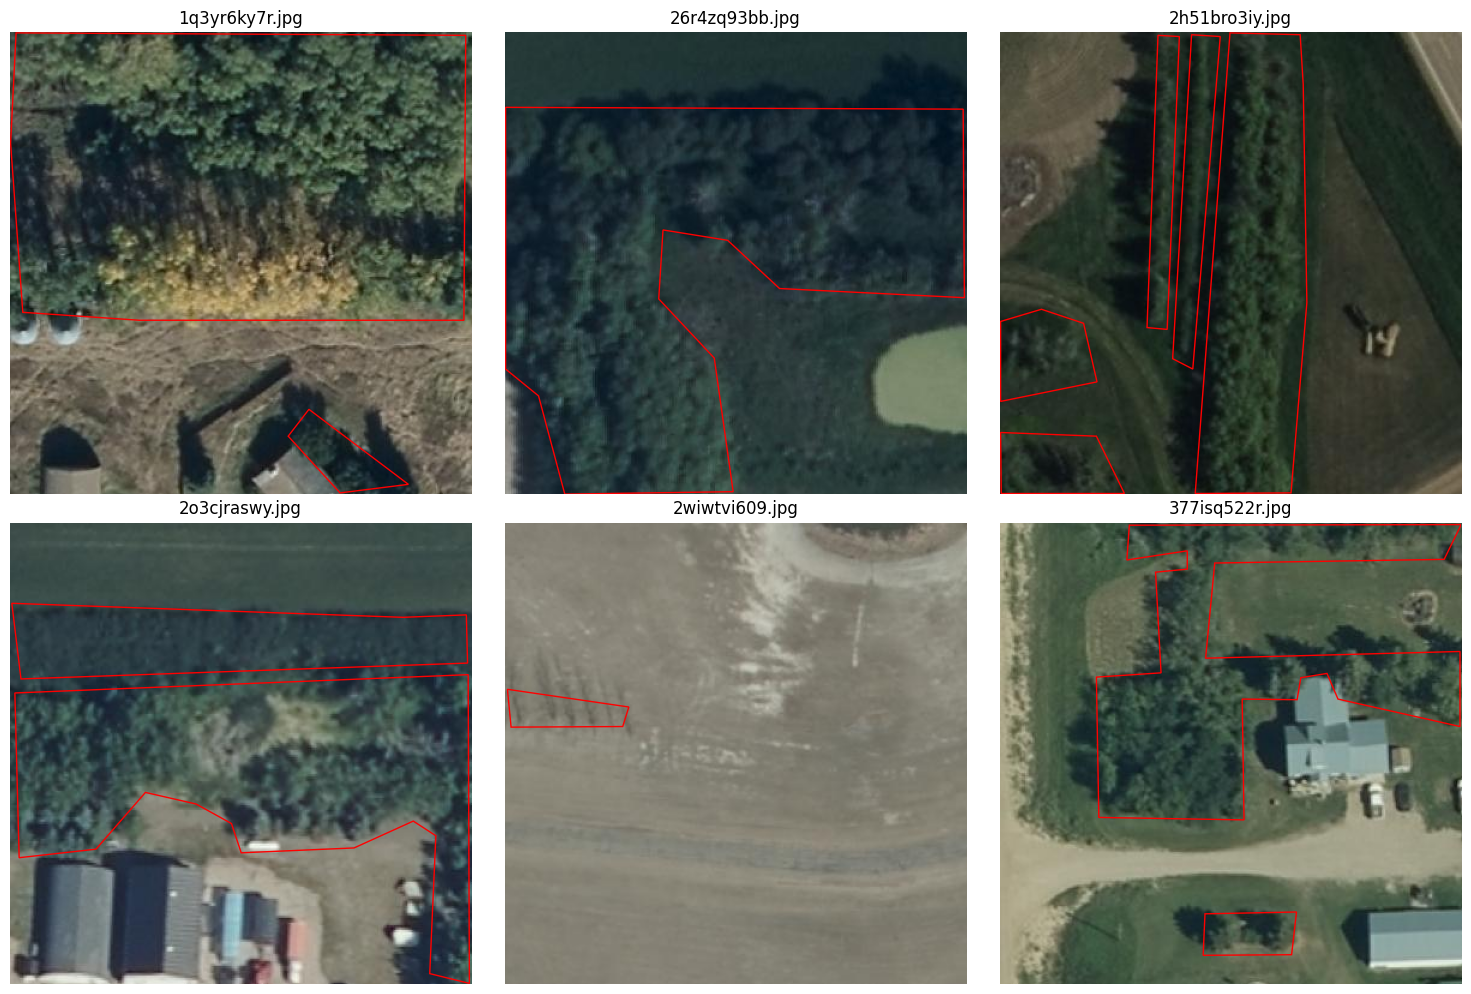

In [86]:
files = sorted(os.listdir(image_folder_path))

plt.figure(figsize=(15, 10))
for i in range(min(6, len(files))):
    img_filename = files[i]
    img_path = os.path.join(image_folder_path, img_filename)
    img = Image.open(img_path)

    ax = plt.subplot(2, 3, i + 1)
    ax.imshow(img)
    ax.set_title(img_filename)
    ax.axis('off')

    if img_filename in annotations_dict:
        for annotation in annotations_dict[img_filename]:
            if 'segmentation' in annotation and annotation['segmentation']:
                segmentations = annotation['segmentation']
                if isinstance(segmentations, list):
                    for seg in segmentations:
                        polygon = np.array(seg).reshape(-1, 2)
                        poly_patch = patches.Polygon(polygon, linewidth=1, edgecolor='red', facecolor='none')
                        ax.add_patch(poly_patch)

plt.tight_layout()
plt.show()

#### Split Data into Train, Validation, and Test Sets
We will now split our dataset into training (70%), validation (15%), and testing (15%) sets and create the directory structure required by YOLO.

In [87]:
base_dir = 'shelterbelt_dataset' # Use a relative path to create the dataset in the project folder

# Clean up previous runs to ensure a fresh start
if os.path.exists(base_dir):
    print(f"Removing existing dataset directory: {base_dir}")
    shutil.rmtree(base_dir)

# Create directories for train, val, and test sets
for split in ['train', 'val', 'test']:
    os.makedirs(os.path.join(base_dir, split, 'images'), exist_ok=True)
    os.makedirs(os.path.join(base_dir, split, 'labels'), exist_ok=True)

# Get the list of image filenames
image_filenames = list(annotations_dict.keys())

# Split the data: 70% train, 15% validation, 15% test
train_files, temp_files = train_test_split(image_filenames, test_size=0.3, random_state=42)
val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42) # 0.5 of 0.3 is 0.15

print(f"Total images: {len(image_filenames)}")
print(f"Training images: {len(train_files)}")
print(f"Validation images: {len(val_files)}")
print(f"Testing images: {len(test_files)}")

Total images: 98
Training images: 68
Validation images: 15
Testing images: 15


#### Convert Annotations to YOLO Format and Organize Files
YOLO requires a specific format for its label files (`.txt`). Each row in the file represents one object: `class_id center_x center_y width height`. The coordinates and dimensions are normalized relative to the image size. This code converts our COCO-style annotations into YOLO format and copies the images and new label files into the correct train/val/test directories.

In [88]:
def coco_to_yolo(annotations, image_width, image_height, category_mapping):
    """
    Converts a list of COCO-formatted annotations to a list of YOLO-formatted annotation strings.

    Args:
        annotations (list): A list of annotation dictionaries for a single image.
        image_width (int): The width of the image.
        image_height (int): The height of the image.
        category_mapping (dict): A dictionary mapping original COCO category IDs to
                                 0-indexed YOLO class IDs.

    Returns:
        list: A list of strings, where each string is a YOLO-formatted annotation.
    """
    yolo_annotations = []
    for ann in annotations:
        original_category_id = ann.get('category_id')
        
        # Skip this annotation if it's not one of the classes we want to map
        if original_category_id is None or original_category_id not in category_mapping:
            continue

        # Map the original COCO category ID to the new YOLO 0-indexed ID
        yolo_class_id = category_mapping[original_category_id]
        
        x_min, y_min, width, height = ann['bbox']
        
        # Normalize coordinates for YOLO format
        x_center = (x_min + width / 2) / image_width
        y_center = (y_min + height / 2) / image_height
        w_normalized = width / image_width
        h_normalized = height / image_height
        
        yolo_annotations.append(f"{yolo_class_id} {x_center:.6f} {y_center:.6f} {w_normalized:.6f} {h_normalized:.6f}")
        
    return yolo_annotations

In [89]:
# Based on the YAML and the example COCO file above:
# COCO ID 18 ("Forest") maps to YOLO ID 0
# COCO ID 25 ("Shelterbelt") maps to YOLO ID 1
category_mapping = {
    1: 0,
    2: 1
}

In [90]:
# def coco_to_yolo(annotations, image_width, image_height):
#     yolo_annotations = []
#     for ann in annotations:
#         x_min, y_min, width, height = ann['bbox']
#         # Since we have only one class ('SHBELT'), its index must be 0, as defined in shelterbelt.yaml.
#         # We ignore the original category_id from the COCO file and hardcode it to 0.
#         category_id = 0
#         x_center = (x_min + width / 2) / image_width
#         y_center = (y_min + height / 2) / image_height
#         w_normalized = width / image_width
#         h_normalized = height / image_height
#         yolo_annotations.append(f"{category_id} {x_center:.6f} {y_center:.6f} {w_normalized:.6f} {h_normalized:.6f}")
#     return yolo_annotations

def process_and_copy_files(file_list, split_name):
    image_dest_dir = os.path.join(base_dir, split_name, 'images')
    label_dest_dir = os.path.join(base_dir, split_name, 'labels')
    
    for filename in file_list:
        shutil.copy(os.path.join(image_folder_path, filename), os.path.join(image_dest_dir, filename))
        
        img_info = next((img for img in coco_data['images'] if img['file_name'] == filename), None)
        
        # Only create a label file if the image has annotations.
        # This prevents creating empty .txt files, which causes the 'No valid images found' error.
        if img_info and filename in annotations_dict and annotations_dict[filename]:
            yolo_labels = coco_to_yolo(annotations_dict[filename], img_info['width'], img_info['height'], category_mapping)
            if yolo_labels:
                label_filename = os.path.splitext(filename)[0] + '.txt'
                label_filepath = os.path.join(label_dest_dir, label_filename)
                with open(label_filepath, 'w') as f:
                    f.write('\n'.join(yolo_labels))

print("Processing and copying files...")
process_and_copy_files(train_files, 'train')
process_and_copy_files(val_files, 'val')
process_and_copy_files(test_files, 'test')
print("Data division complete.")

Processing and copying files...
Data division complete.


#### Create YOLO Dataset Configuration File (`data.yaml`)
Finally, we create a YAML file that tells YOLO where to find the training and validation data, and what the class names are.

In [91]:
%%writefile shelterbelt.yaml
# YOLOv8 dataset configuration file

path: ./shelterbelt_dataset  # Root directory of the dataset (relative to project root)
train: train/images  # Path to training images (relative to 'path')
val: val/images      # Path to validation images (relative to 'path')
test: test/images     # Path to test images (relative to 'path')

# Class names
names:
  0: SHBELT
  1: FOREST

Overwriting shelterbelt.yaml


### 2. Configure MLflow Tracking

By default, MLflow logs data to a local `mlruns` directory. We can set a custom experiment name to keep our runs organized. You can view the results by running `mlflow ui` in your terminal and navigating to `http://127.0.0.1:5000`.

In [103]:
!rm -rf mlruns

In [104]:
# End any active run to prevent conflicts from previous interrupted sessions
if mlflow.active_run():
    mlflow.end_run()

In [94]:
mlflow.set_experiment("usask-shelterbelt-yolo-experiment-01")

print(f"MLflow tracking URI: {mlflow.get_tracking_uri()}")
print(f"Current experiment: '{mlflow.get_experiment_by_name('usask-shelterbelt-yolo-experiment-01').name}'")

MLflow tracking URI: /home/morteza/forest_dl_project/usask_shelterbelt_yolo/runs/mlflow
Current experiment: 'usask-shelterbelt-yolo-experiment-01'


### 3. Load a Pre-trained YOLO Model

We'll start with a pre-trained YOLOv8 nano model (`yolov8n.pt`), which is the smallest and fastest variant. The model will be downloaded automatically on first use.

In [105]:
model = YOLO('yolo11n.pt')

In [ ]:
# !yolo settings mlflow=True

In [47]:
# !yolo cfg

### 4. Train the Model with Autologging

The `ultralytics` library has built-in MLflow integration. When you call `model.train()`, it automatically detects that MLflow is installed and logs everything to an active run. We'll use `with mlflow.start_run():` to create a run for the training job.

For this demo, we use the `coco128.yaml` dataset. **You should replace this with the path to your shelterbelt dataset's YAML configuration file.**

In [106]:
with mlflow.start_run() as run:
    run_id = run.info.run_id
    print(f"Starting MLflow run with ID: {run_id}")

    # The training process will automatically log to this run.
    results = model.train(
        project="USASK_Shelterbelt_YOLO",
        data='shelterbelt.yaml',  # Use the new, relative-path config file
        batch= 16,
        epochs=50,             # Using a small number of epochs for a quick test
        imgsz=640,
        verbose= True,
        val= True,
    )

print("\nTraining complete.")
print(f"Run '{run_id}' has been logged to MLflow.")
print("Go to http://127.0.0.1:5000 to see the results.")

Starting MLflow run with ID: d4e6d08a1d994092a5e050282ebf27c2
Ultralytics 8.3.168 🚀 Python-3.11.2 torch-2.7.1+cu126 CUDA:0 (NVIDIA GeForce RTX 3090, 24576MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=shelterbelt.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, 

train: Scanning /home/morteza/forest_dl_project/usask_shelterbelt_yolo/shelterbelt_dataset/train/labels.cache... 68 images, 0 backgrounds, 0 corrupt: 100%|██████████| 68/68 [00:00<?, ?it/s]


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 225.8±100.0 MB/s, size: 18.4 KB)


val: Scanning /home/morteza/forest_dl_project/usask_shelterbelt_yolo/shelterbelt_dataset/val/labels.cache... 15 images, 0 backgrounds, 0 corrupt: 100%|██████████| 15/15 [00:00<?, ?it/s]


Plotting labels to USASK_Shelterbelt_YOLO/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)


2025/07/21 23:57:01 WARNING mlflow.utils.autologging_utils: MLflow sklearn autologging is known to be compatible with 1.3.0 <= scikit-learn <= 1.7.0, but the installed version is 1.7.1. If you encounter errors during autologging, try upgrading / downgrading scikit-learn to a compatible version, or try upgrading MLflow.
2025/07/21 23:57:01 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


MLflow: logging run_id(d4e6d08a1d994092a5e050282ebf27c2) to /home/morteza/forest_dl_project/usask_shelterbelt_yolo/runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri /home/morteza/forest_dl_project/usask_shelterbelt_yolo/runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to USASK_Shelterbelt_YOLO/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.49G      1.796      3.323      1.867         11        640: 100%|██████████| 5/5 [00:01<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.91it/s]

                   all         15         28    0.00451      0.804     0.0421     0.0132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.49G      1.684      3.372      1.862         13        640: 100%|██████████| 5/5 [00:00<00:00,  7.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.09it/s]

                   all         15         28    0.00418      0.761      0.035     0.0142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.49G      1.415      3.168      1.554         20        640: 100%|██████████| 5/5 [00:00<00:00,  7.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.13it/s]

                   all         15         28     0.0043      0.783      0.187      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.49G      1.467      3.026      1.593         14        640: 100%|██████████| 5/5 [00:00<00:00,  8.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.82it/s]

                   all         15         28    0.00445      0.804      0.144     0.0819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.49G       1.25      2.956      1.505         10        640: 100%|██████████| 5/5 [00:00<00:00,  8.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.38it/s]

                   all         15         28    0.00537      0.891      0.109     0.0595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.49G      1.359      2.795      1.466         20        640: 100%|██████████| 5/5 [00:00<00:00,  8.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.16it/s]

                   all         15         28    0.00541      0.891      0.128     0.0625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.49G       1.39      2.706      1.627         13        640: 100%|██████████| 5/5 [00:00<00:00,  8.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.54it/s]

                   all         15         28    0.00502      0.748      0.129     0.0572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.49G      1.427       2.61      1.553         23        640: 100%|██████████| 5/5 [00:00<00:00,  9.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.05it/s]

                   all         15         28     0.0057      0.813       0.24     0.0859



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.49G      1.451      2.501      1.593         18        640: 100%|██████████| 5/5 [00:00<00:00,  8.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.13it/s]

                   all         15         28    0.00532      0.691      0.122     0.0541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.49G       1.44      2.488      1.582         15        640: 100%|██████████| 5/5 [00:00<00:00,  9.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.75it/s]

                   all         15         28      0.653     0.0652     0.0864     0.0338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.49G      1.543      2.401      1.538         22        640: 100%|██████████| 5/5 [00:00<00:00,  8.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.03it/s]

                   all         15         28      0.687      0.104      0.098     0.0511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.49G       1.48      2.515      1.616         15        640: 100%|██████████| 5/5 [00:00<00:00,  9.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.09it/s]

                   all         15         28      0.651      0.087     0.0732     0.0309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.49G      1.397      2.319      1.545         16        640: 100%|██████████| 5/5 [00:00<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.28it/s]

                   all         15         28      0.651     0.0652      0.126     0.0528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.49G      1.404      2.269      1.537         27        640: 100%|██████████| 5/5 [00:00<00:00,  8.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.64it/s]

                   all         15         28      0.765      0.172      0.176     0.0667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.49G      1.459      2.386      1.619          9        640: 100%|██████████| 5/5 [00:00<00:00,  9.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.34it/s]

                   all         15         28      0.644      0.217      0.133     0.0489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.49G      1.345      2.197      1.492         11        640: 100%|██████████| 5/5 [00:00<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.13it/s]

                   all         15         28      0.598      0.152      0.112     0.0442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.49G      1.318      2.165      1.458         17        640: 100%|██████████| 5/5 [00:00<00:00,  9.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.91it/s]

                   all         15         28       0.57      0.239       0.21     0.0821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.49G      1.449      2.146      1.563         14        640: 100%|██████████| 5/5 [00:00<00:00,  9.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.86it/s]

                   all         15         28      0.568      0.261      0.183     0.0623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.49G      1.354       2.06      1.456         18        640: 100%|██████████| 5/5 [00:00<00:00,  9.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.32it/s]

                   all         15         28      0.575      0.087     0.0942     0.0249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.49G       1.33      2.045      1.447         14        640: 100%|██████████| 5/5 [00:00<00:00,  9.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.70it/s]

                   all         15         28      0.536      0.196      0.195      0.047



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.49G      1.333      2.052      1.438         23        640: 100%|██████████| 5/5 [00:00<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.29it/s]

                   all         15         28      0.624     0.0933      0.129     0.0379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.49G      1.334      1.974      1.447         25        640: 100%|██████████| 5/5 [00:00<00:00,  9.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.62it/s]

                   all         15         28      0.655      0.217      0.143     0.0492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.49G      1.351      2.028      1.478         21        640: 100%|██████████| 5/5 [00:00<00:00,  9.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.15it/s]

                   all         15         28      0.661      0.152      0.138     0.0609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.49G      1.225      1.997      1.462         14        640: 100%|██████████| 5/5 [00:00<00:00,  8.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.05it/s]

                   all         15         28      0.719       0.13      0.129     0.0463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.49G      1.264      1.953      1.461         17        640: 100%|██████████| 5/5 [00:00<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.79it/s]


                   all         15         28       0.61      0.087      0.133     0.0487

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.49G      1.264      1.889      1.433         15        640: 100%|██████████| 5/5 [00:00<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.63it/s]

                   all         15         28      0.702      0.152      0.142     0.0549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.49G       1.32      1.982      1.472         24        640: 100%|██████████| 5/5 [00:00<00:00,  9.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.69it/s]

                   all         15         28      0.727       0.13      0.155     0.0575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.49G      1.123      1.774      1.358         12        640: 100%|██████████| 5/5 [00:00<00:00,  9.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.87it/s]

                   all         15         28      0.659      0.196      0.115     0.0375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.49G      1.223      1.795      1.395         17        640: 100%|██████████| 5/5 [00:00<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.67it/s]


                   all         15         28      0.678      0.152      0.118     0.0403

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.49G      1.311      1.854       1.44         23        640: 100%|██████████| 5/5 [00:00<00:00,  9.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.99it/s]

                   all         15         28      0.731      0.087      0.107     0.0362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.49G      1.183      1.754      1.376         19        640: 100%|██████████| 5/5 [00:00<00:00,  9.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.83it/s]

                   all         15         28      0.658       0.13      0.155     0.0503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.49G      1.177      1.771      1.371         13        640: 100%|██████████| 5/5 [00:00<00:00,  9.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.99it/s]

                   all         15         28      0.649      0.174      0.176       0.07



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.49G       1.08      1.653      1.326         19        640: 100%|██████████| 5/5 [00:00<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.00it/s]

                   all         15         28       0.83      0.212      0.226     0.0741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.49G      1.206      1.853      1.419         16        640: 100%|██████████| 5/5 [00:00<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.97it/s]


                   all         15         28      0.789      0.217      0.236     0.0815

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.49G      1.179      1.771      1.374         19        640: 100%|██████████| 5/5 [00:00<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.71it/s]

                   all         15         28      0.169      0.261      0.224     0.0821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.49G      1.129      1.616      1.285         17        640: 100%|██████████| 5/5 [00:00<00:00,  9.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.41it/s]

                   all         15         28      0.206      0.583      0.231     0.0921



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.49G      1.106      1.615      1.282         23        640: 100%|██████████| 5/5 [00:00<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.77it/s]


                   all         15         28      0.275      0.561      0.272     0.0826

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.49G      1.054      1.547      1.257         20        640: 100%|██████████| 5/5 [00:00<00:00,  9.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.77it/s]

                   all         15         28      0.349      0.539      0.303      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.49G      1.228      1.776      1.392         20        640: 100%|██████████| 5/5 [00:00<00:00,  9.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.05it/s]

                   all         15         28      0.387      0.561      0.314      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.49G       1.11        1.6      1.299         20        640: 100%|██████████| 5/5 [00:00<00:00,  9.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.09it/s]

                   all         15         28      0.353      0.577      0.294      0.114


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.49G      1.116       2.09      1.368          6        640: 100%|██████████| 5/5 [00:00<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.53it/s]

                   all         15         28      0.296      0.583      0.281      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.49G      1.112      1.852       1.39          5        640: 100%|██████████| 5/5 [00:00<00:00,  9.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.70it/s]

                   all         15         28      0.277      0.539      0.278      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.49G      1.306      2.174      1.406          7        640: 100%|██████████| 5/5 [00:00<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.13it/s]


                   all         15         28      0.362      0.352      0.292      0.138

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.49G      1.134      1.785      1.378         10        640: 100%|██████████| 5/5 [00:00<00:00,  9.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.95it/s]

                   all         15         28      0.292      0.617      0.295      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.49G      1.082      1.864      1.297          6        640: 100%|██████████| 5/5 [00:00<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.00it/s]

                   all         15         28      0.359      0.485      0.314      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.49G      1.203      1.903      1.486          9        640: 100%|██████████| 5/5 [00:00<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.42it/s]

                   all         15         28      0.381      0.582      0.353      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      2.49G      1.128      1.862      1.377         10        640: 100%|██████████| 5/5 [00:00<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.90it/s]

                   all         15         28      0.296      0.596      0.327      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.49G      1.067       1.76      1.262         11        640: 100%|██████████| 5/5 [00:00<00:00,  9.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.26it/s]

                   all         15         28      0.427      0.589      0.358      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.49G     0.9804      1.718      1.289          7        640: 100%|██████████| 5/5 [00:00<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.09it/s]

                   all         15         28      0.448      0.535      0.368      0.177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.49G     0.8557      1.642      1.197          6        640: 100%|██████████| 5/5 [00:00<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.25it/s]


                   all         15         28      0.517        0.6      0.419      0.192

50 epochs completed in 0.014 hours.
Optimizer stripped from USASK_Shelterbelt_YOLO/train/weights/last.pt, 5.5MB
Optimizer stripped from USASK_Shelterbelt_YOLO/train/weights/best.pt, 5.5MB

Validating USASK_Shelterbelt_YOLO/train/weights/best.pt...
Ultralytics 8.3.168 🚀 Python-3.11.2 torch-2.7.1+cu126 CUDA:0 (NVIDIA GeForce RTX 3090, 24576MiB)
YOLO11n summary (fused): 100 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.04it/s]


                   all         15         28      0.517      0.601       0.42      0.191
                SHBELT         12         23       0.49      0.478      0.384      0.166
                FOREST          4          5      0.544      0.723      0.455      0.217
Speed: 0.1ms preprocess, 0.9ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to USASK_Shelterbelt_YOLO/train
MLflow: results logged to /home/morteza/forest_dl_project/usask_shelterbelt_yolo/runs/mlflow
MLflow: disable with 'yolo settings mlflow=False'

Training complete.
Run 'd4e6d08a1d994092a5e050282ebf27c2' has been logged to MLflow.
Go to http://127.0.0.1:5000 to see the results.


Running prediction with confidence threshold: 0.1


image 1/1 /home/morteza/forest_dl_project/usask_shelterbelt_yolo/shelterbelt_dataset/test/images/vn58251usa.jpg: 640x640 3 SHBELTs, 9.9ms
Speed: 3.4ms preprocess, 9.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/morteza/forest_dl_project/usask_shelterbelt_yolo/shelterbelt_dataset/test/images/2wiwtvi609.jpg: 640x640 (no detections), 10.1ms
Speed: 2.9ms preprocess, 10.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/morteza/forest_dl_project/usask_shelterbelt_yolo/shelterbelt_dataset/test/images/6o9wtyewsn.jpg: 640x640 2 SHBELTs, 15.3ms
Speed: 2.9ms preprocess, 15.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/morteza/forest_dl_project/usask_shelterbelt_yolo/shelterbelt_dataset/test/images/5kkvqwjr3d.jpg: 640x640 1 FOREST, 10.3ms
Speed: 2.2ms preprocess, 10.3ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640

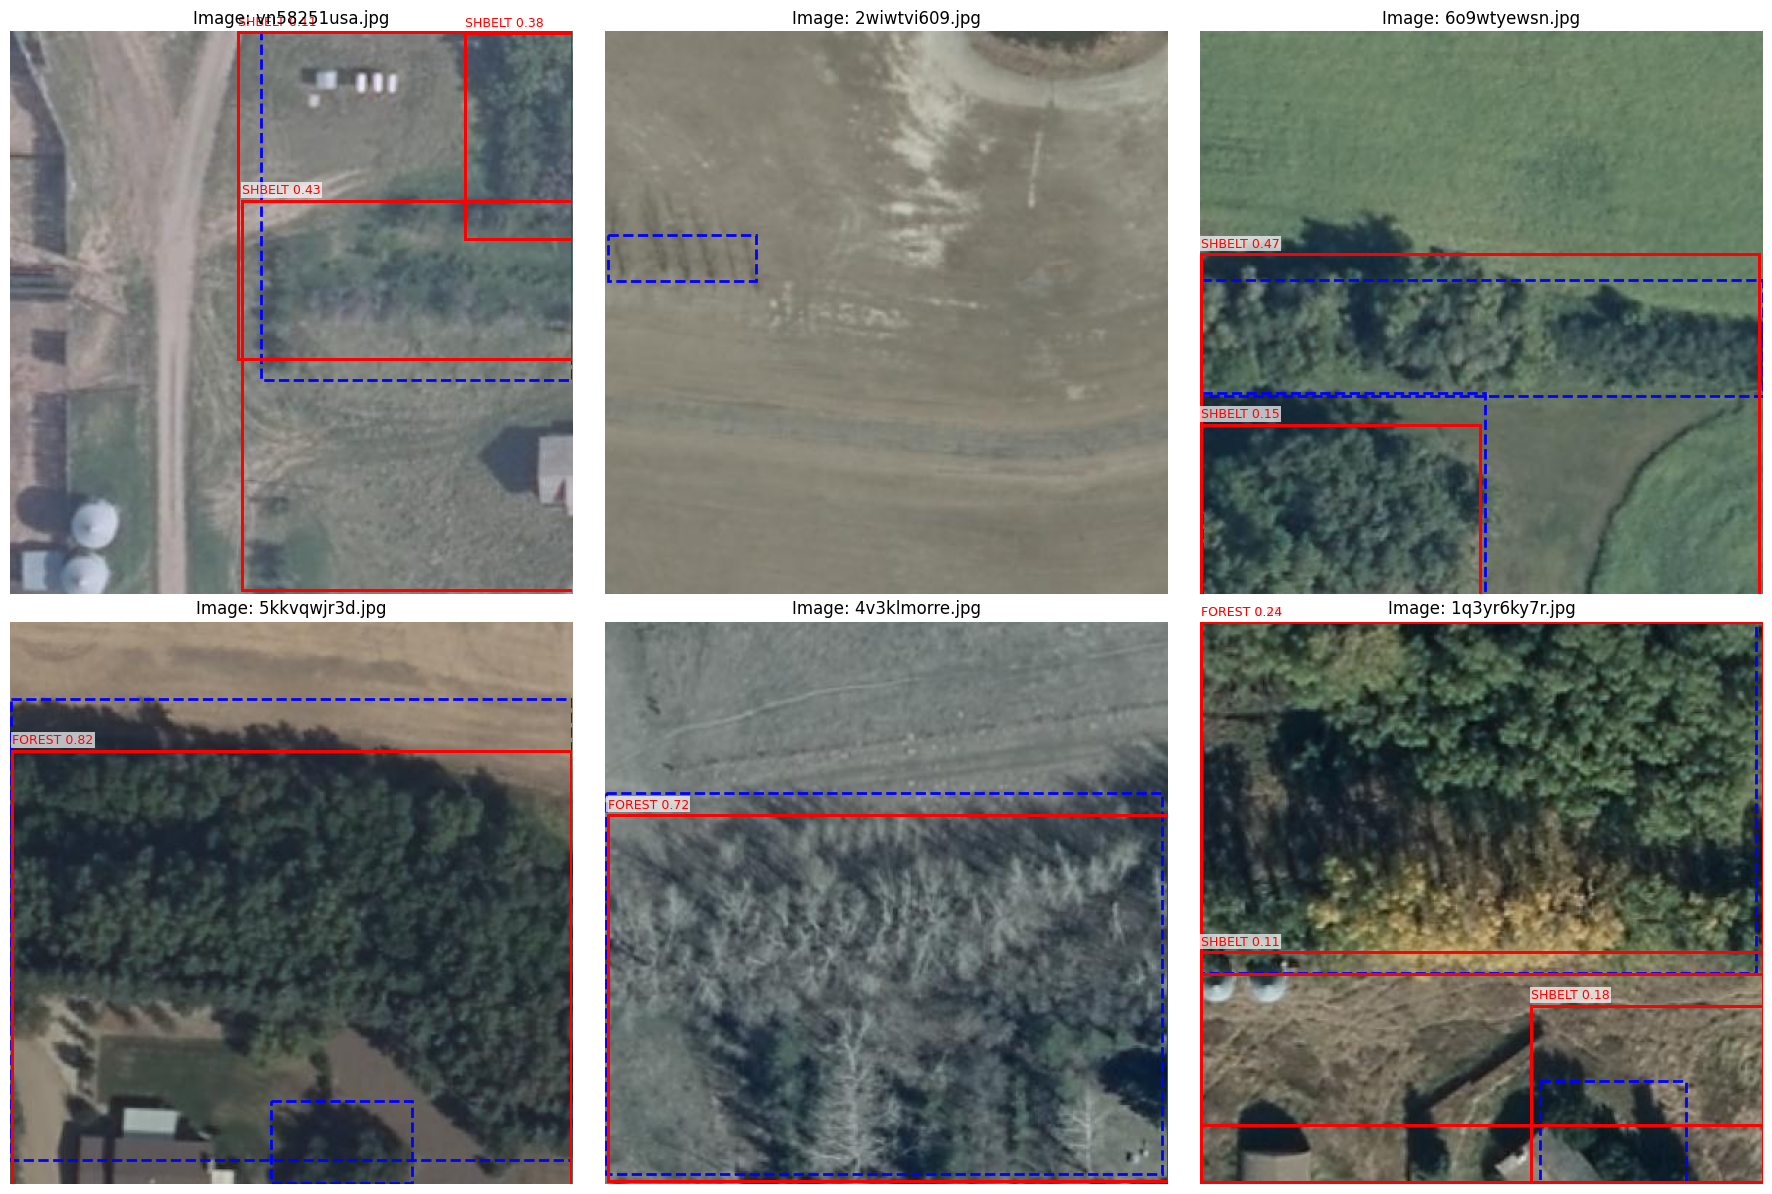


--- Prediction Statistics ---

Image: vn58251usa.jpg
  - Ground Truth: 1
  - Predictions:  3

Image: 2wiwtvi609.jpg
  - Ground Truth: 1
  - Predictions:  0

Image: 6o9wtyewsn.jpg
  - Ground Truth: 2
  - Predictions:  2

Image: 5kkvqwjr3d.jpg
  - Ground Truth: 2
  - Predictions:  1

Image: 4v3klmorre.jpg
  - Ground Truth: 1
  - Predictions:  1

Image: 1q3yr6ky7r.jpg
  - Ground Truth: 2
  - Predictions:  4


In [107]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os

# Assume 'model', 'test_files', 'test_image_path', and 'annotations_dict' are already defined

# --- Recommended Code ---

def draw_boxes(ax, boxes, color, style='-', is_prediction=False, class_names=None):
    """
    Draws bounding boxes and annotations on a matplotlib Axes object.
    Handles both ground truth and YOLO prediction formats.
    """
    for box in boxes:
        if is_prediction:
            # For YOLO prediction objects (results.boxes), which contain coordinates,
            # confidence, and class id.

            # Move tensor from GPU to CPU and convert to NumPy
            coords = box.xyxy[0].cpu().numpy()
            x_min, y_min, x_max, y_max = coords

            # Draw the rectangle
            rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                               fill=False, color=color, linestyle=style, linewidth=2)
            ax.add_patch(rect)

            # --- ADD ANNOTATION TEXT ---
            # Get confidence and class ID
            conf = box.conf[0].cpu().item()  # .item() gets the scalar value
            cls_id = int(box.cls[0].cpu().item())

            # Create the label text using class names if provided
            if class_names:
                label = f"{class_names[cls_id]} {conf:.2f}"
            else:
                label = f"Cls {cls_id}: {conf:.2f}"

            # Add the text annotation above the box
            ax.text(x_min, y_min - 5, label, color=color, fontsize=9,
                    bbox=dict(facecolor='white', alpha=0.7, pad=1, edgecolor='none'))
        else:
            # For ground truth boxes [x_min, y_min, width, height]
            x_min, y_min, width, height = box
            rect = plt.Rectangle((x_min, y_min), width, height,
                               fill=False, color=color, linestyle=style, linewidth=2)
        ax.add_patch(rect)

# --- Main Visualization and Prediction Loop ---

# Store results to avoid re-running prediction
prediction_results = {}
CONFIDENCE_THRESHOLD = 0.1  # Lower the threshold to see weak predictions

print(f"Running prediction with confidence threshold: {CONFIDENCE_THRESHOLD}\n")

for test_file in test_files:
    img_path = os.path.join(test_image_path, test_file)
    # Run prediction only ONCE per image
    results = model.predict(img_path, conf=CONFIDENCE_THRESHOLD)
    prediction_results[test_file] = results[0] # Store the results for the first image

# Create a figure for plotting
num_samples = min(6, len(test_files))
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for idx, test_file in enumerate(test_files[:num_samples]):
    # Load and display the image
    img_path = os.path.join(test_image_path, test_file)
    img = Image.open(img_path)
    axes[idx].imshow(img)
    
    # Get and draw ground truth annotations
    if test_file in annotations_dict:
        ground_truth = [ann['bbox'] for ann in annotations_dict[test_file]]
        draw_boxes(axes[idx], ground_truth, 'blue', style='--', is_prediction=False)
    
    # Get and draw model predictions from our stored results
    predictions = prediction_results[test_file]
    if len(predictions.boxes) > 0:
        # Pass the model.names dictionary to display class labels
        draw_boxes(axes[idx], predictions.boxes, 'red', style='-', is_prediction=True, class_names=model.names)
    
    axes[idx].set_title(f'Image: {test_file}')
    axes[idx].axis('off')

# Hide any unused subplots
for i in range(num_samples, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Print prediction statistics from our stored results
print("\n--- Prediction Statistics ---")
for test_file in test_files[:num_samples]:
    predictions = prediction_results[test_file]
    num_preds = len(predictions.boxes)
    num_gt = len(annotations_dict.get(test_file, []))
    
    print(f"\nImage: {test_file}")
    print(f"  - Ground Truth: {num_gt}")
    print(f"  - Predictions:  {num_preds}")
